In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import wandb
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR


In [2]:
wandb.init(project="resu7")


wandb: Currently logged in as: boredxmc (boredxmc-school). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [3]:
file_path = r'D:\24phd7039\biomedical-research\datasets\csv_files\datasets_subject_01_to_10_scidata\GDN0009\GDN0009_1_Resting.csv'
df = pd.read_csv(file_path)

# Selecting only relevant columns
df = df[['radar_i', 'radar_q', 'tfm_ecg2']].dropna()

# Convert to numpy arrays
X = df[['radar_i', 'radar_q']].values.astype(np.float32)  # Inputs
y = df[['tfm_ecg2']].values.astype(np.float32)  # Target

# Standardize the inputs
scaler_x = StandardScaler()
X = scaler_x.fit_transform(X)  # Standardize input features
    

# Convert to torch tensors
X_tensor = torch.tensor(X)  # Shape: (batch_size, num_features)
y_tensor = torch.tensor(y)

# Fix shape for Conv1D (add seq_len=1)
X_tensor = X_tensor.unsqueeze(-1)  # Shape: (batch_size, num_features, 1)

# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=6000, shuffle=True)

print(f"Loaded dataset: {len(dataset)} samples")

Loaded dataset: 1298800 samples


In [4]:
import torch.nn.functional as F

class ResUNet1D(nn.Module):
    def __init__(self, input_channels=2, output_channels=1):
        super(ResUNet1D, self).__init__()

        self.conv1 = nn.Sequential(nn.Conv1d(input_channels, 64, kernel_size=5, padding=2), nn.BatchNorm1d(64), nn.SiLU())
        self.conv2 = nn.Sequential(nn.Conv1d(64, 128, kernel_size=5, padding=2), nn.BatchNorm1d(128), nn.SiLU())
        self.conv3 = nn.Sequential(nn.Conv1d(128, 256, kernel_size=5, padding=2), nn.BatchNorm1d(256), nn.SiLU())
        self.conv4 = nn.Sequential(nn.Conv1d(256, 512, kernel_size=5, padding=2), nn.BatchNorm1d(512), nn.SiLU())
        self.conv5 = nn.Sequential(nn.Conv1d(512, 1024, kernel_size=5, padding=2), nn.BatchNorm1d(1024), nn.SiLU())
        
        self.conv6 = nn.Sequential(nn.Conv1d(1024 + 512, 512, kernel_size=5, padding=2), nn.BatchNorm1d(512), nn.SiLU())
        self.conv7 = nn.Sequential(nn.Conv1d(512 + 256, 256, kernel_size=5, padding=2), nn.BatchNorm1d(256), nn.SiLU())
        self.conv8 = nn.Sequential(nn.Conv1d(256 + 128, 128, kernel_size=5, padding=2), nn.BatchNorm1d(128), nn.SiLU())
        self.conv9 = nn.Sequential(nn.Conv1d(128 + 64, 64, kernel_size=5, padding=2), nn.BatchNorm1d(64), nn.SiLU())
        self.conv10 = nn.Conv1d(64, output_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)

        x6 = self.conv6(torch.cat([x5, x4], dim=1))
        x7 = self.conv7(torch.cat([x6, x3], dim=1))
        x8 = self.conv8(torch.cat([x7, x2], dim=1))
        x9 = self.conv9(torch.cat([x8, x1], dim=1))
        x10 = self.conv10(x9)

        return x10.squeeze(-1)


# Model parameters
learning_rate = 0.0001
epochs = 10

# Initialize model, loss function, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResUNet1D(input_channels=2, output_channels=1).to(device)
loss_fn = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Watch model with wandb
wandb.watch(model)


In [5]:


# Define your optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# StepLR scheduler with step_size=5 and gamma=0.1 (reduce LR by 10x every 5 epochs)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

def train_model(model, train_loader, epochs):
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            predictions = model(inputs)
            loss = loss_fn(predictions, targets)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient Clipping
            optimizer.step()

            epoch_loss += loss.item()
            wandb.log({"Batch Loss": loss.item()})

        avg_epoch_loss = epoch_loss / len(train_loader)
        wandb.log({"Epoch Loss": avg_epoch_loss})
        scheduler.step()

        print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_epoch_loss:.4f}")

    return model


# Train the model
model = train_model(model, train_loader, epochs)


Epoch [1/10] Loss: 0.0495
Epoch [2/10] Loss: 0.0478
Epoch [3/10] Loss: 0.0476
Epoch [4/10] Loss: 0.0474
Epoch [5/10] Loss: 0.0472
Epoch [6/10] Loss: 0.0471
Epoch [7/10] Loss: 0.0470
Epoch [8/10] Loss: 0.0469
Epoch [9/10] Loss: 0.0468
Epoch [10/10] Loss: 0.0468


In [6]:
# Save the model
torch.save(model.state_dict(), "resunet1d_model.pth")
print("Model saved.")

# Evaluate the model
def evaluate_model(model, data_loader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            predictions = model(inputs)
            loss = loss_fn(predictions, targets)
            total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    print(f"Evaluation Loss: {avg_loss:.4f}")
    wandb.log({"Evaluation Loss": avg_loss})
    return avg_loss

# Evaluate on training data
evaluate_model(model, train_loader)


Model saved.
Evaluation Loss: 0.0466


0.04655065615811656

In [13]:
import torch
import numpy as np
import pandas as pd

def save_predictions(model, data_loader, input_csv_path, output_csv_path):
    model.eval()
    predictions_list = []
    actual_list = []

    # Load the original CSV file
    df = pd.read_csv(input_csv_path)

    # Assuming tfm_ecg2 is the column to be replaced
    tfm_ecg2_column_index = 2  # Adjust based on the actual column index of tfm_ecg2 in your CSV

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            predictions = model(inputs)

            # Append predictions and actual values
            predictions_list.append(predictions.cpu().numpy())
            actual_list.append(targets.cpu().numpy())

    # Concatenate the predictions and actual values
    predictions_array = np.concatenate(predictions_list, axis=0)
    actual_array = np.concatenate(actual_list, axis=0)

    # Flatten the arrays
    predictions_array = predictions_array.flatten()
    actual_array = actual_array.flatten()

    # Debugging statements
    print(f"Predictions shape: {predictions_array.shape}")
    print(f"Actual shape: {actual_array.shape}")

    if predictions_array.shape[0] != actual_array.shape[0]:
        print("Warning: Predictions and Actual arrays do not have the same length!")

    # Ensure we don't overwrite the existing CSV structure
    num_samples = min(len(df), len(predictions_array))
    df = df.iloc[:num_samples]  # Trim DataFrame if needed

    # Replace the tfm_ecg2 column with the predicted values
    df.iloc[:, tfm_ecg2_column_index] = predictions_array[:num_samples]

    # Save the modified DataFrame
    df.to_csv(output_csv_path, index=False)
    print(f"Saved updated CSV to {output_csv_path}")

# Example usage:
input_csv_path = r'D:\24phd7039\biomedical-research\datasets\csv_files\datasets_subject_01_to_10_scidata\GDN0003\GDN0003_1_Resting.csv'
output_csv_path = r'D:\24phd7039\biomedical-research\ml_files\utils\plot_folder\GDN0003\combined.csv'
save_predictions(model, train_loader, input_csv_path, output_csv_path)


Predictions shape: (1298800,)
Actual shape: (1298800,)
Saved updated CSV to D:\24phd7039\biomedical-research\ml_files\utils\plot_folder\GDN0003\combined.csv


MSE: 0.0466, MAE: 0.1342, RMSE: 0.2158


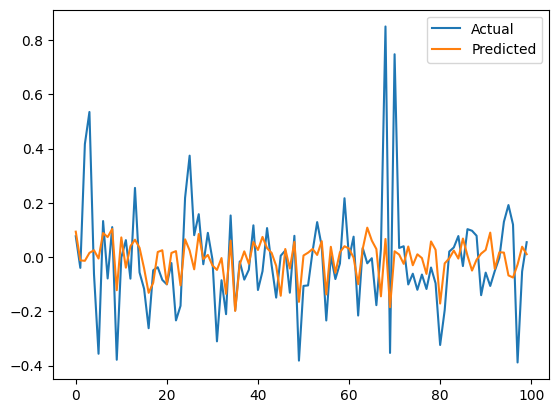

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

csv_path = "resunet1d_predictions.csv"
df = pd.read_csv(csv_path)

predictions = df["Predicted"].values
actuals = df["Actual"].values

mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mse)

print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}")

plt.plot(actuals[:100], label="Actual")
plt.plot(predictions[:100], label="Predicted")
plt.legend()
plt.show()


Mean Squared Error: 0.0466
Mean Absolute Error: 0.1342
Root Mean Squared Error: 0.2158
F1 Score: 0.0031
Accuracy: 0.9783


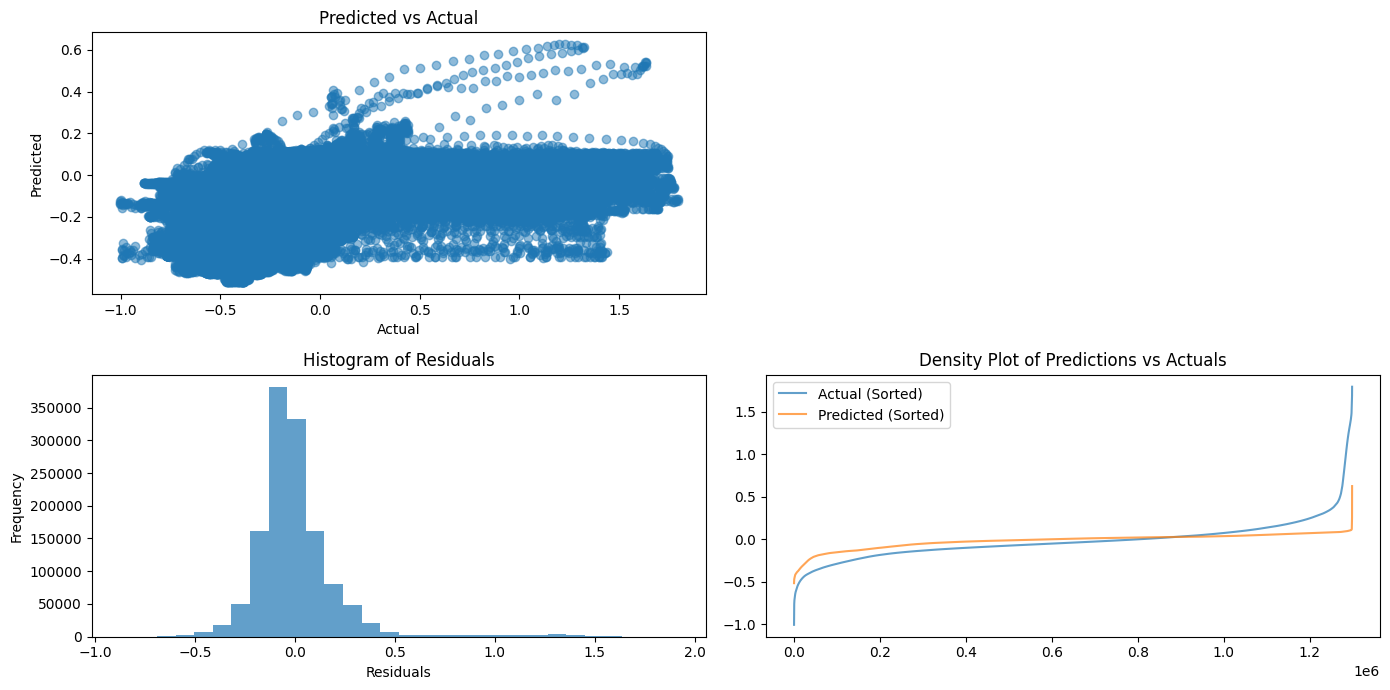

In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score, accuracy_score
import matplotlib.pyplot as plt

# Load the CSV
csv_path = r'D:\24phd7039\biomedical-research\ml_files\models\resunet\resunet1d_predictions.csv'
df = pd.read_csv(csv_path)

# Metrics calculation
predictions = df["Predicted"].values
actuals = df["Actual"].values

# Define a threshold for classification (optional for regression tasks)
threshold = 0.5
predicted_classes = (predictions > threshold).astype(int)
actual_classes = (actuals > threshold).astype(int)

# Regression Metrics
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mse)

# Classification Metrics (if threshold is applied)
f1 = f1_score(actual_classes, predicted_classes)
accuracy = accuracy_score(actual_classes, predicted_classes)

# Print metrics
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Plot graphs
plt.figure(figsize=(14, 7))

# Scatter plot
plt.subplot(2, 2, 1)
plt.scatter(actuals, predictions, alpha=0.5)
plt.title("Predicted vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")



# Residuals Histogram
residuals = actuals - predictions
plt.subplot(2, 2, 3)
plt.hist(residuals, bins=30, alpha=0.7)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")

# Density plot
plt.subplot(2, 2, 4)
plt.plot(sorted(actuals), label="Actual (Sorted)", alpha=0.7)
plt.plot(sorted(predictions), label="Predicted (Sorted)", alpha=0.7)
plt.legend()
plt.title("Density Plot of Predictions vs Actuals")

plt.tight_layout()
plt.show()


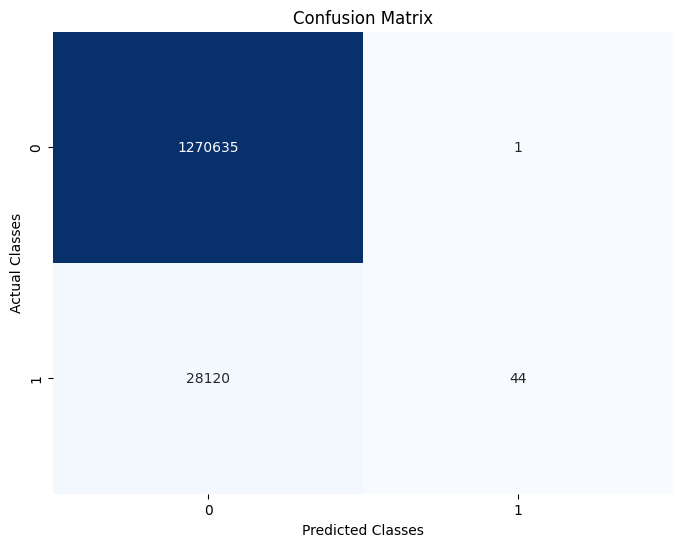

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
conf_matrix = confusion_matrix(actual_classes, predicted_classes)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
plt.show()